Load the image

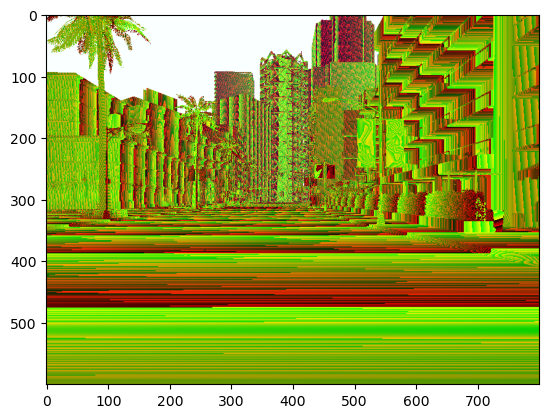

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import MapToGrid as m2g
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D

#Define inverse camera transformation
def get_point_image(point_img,K_inv,Width,Height):
        loc_mat=np.zeros([Height,Width,3])
        static_projection_matrix=np.zeros([Height,Width,3])
        for i in range(Height):
                for j in range(Width):
                        loc_mat[i,j] = [j-Width/2,i-Height/2,1]
                        static_projection_matrix[i,j]=np.dot(K_inv,loc_mat[i,j])
        return static_projection_matrix , loc_mat


# Read Images
img = mpimg.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to check the picture
img2 = mpimg.imread('Rubens test files/Pictures/instance_camera_Sun_Apr_14_20_33_08_2024.png')
depth_data=plt.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array
segment_data=plt.imread('Rubens test files/Pictures/instance_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array

# img = mpimg.imread('Rubens test files/Pictures/depth_camera_Wed_Apr_24_11_29_43_2024 (1).png') #to check the picture
# # img2 = mpimg.imread('Rubens test files/Pictures/instance_camera_Wed_Apr_24_11_29_43_2024.png')
# depth_data=plt.imread('Rubens test files/Pictures/depth_camera_Wed_Apr_24_11_29_43_2024 (1).png') #to get the data as an array
# segment_data=plt.imread('Rubens test files/Pictures/instance_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array

# Output Images
plt.imshow(img)
# plt.imshow(img2)



Initiate variables

In [18]:
depth_Width=depth_data[1,:,0].size
depth_Height=depth_data[:,1,0].size
print([depth_Height,depth_Width])

segment_Width=round(segment_data[1,:,0].size/3)
segment_Height=round(segment_data[:,1,0].size/3)


converted_depth_data=np.zeros([depth_Width,depth_Height])
segment_data=np.round(segment_data*255)


max_sensor_range= 0.4 #in kilometers
scale_factor=100

#convert depth units
R=depth_data[:,:,0]
G=depth_data[:,:,1]
B=depth_data[:,:,2]

normalized = ((R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1))*1000*scale_factor

#calculate projection matrix
fov = 90
im_size_x = 800
im_size_y = 600

f  = im_size_x /(2.0 * math.tan(fov * math.pi / 360))
Cx = im_size_x / 2.0
Cy = im_size_y / 2.0

K = np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]], dtype=np.float64)
K_inv=np.linalg.inv(K)

[rel_coords,camera_index_mat]=get_point_image(normalized,K_inv,depth_Width,depth_Height)

[600, 800]


Calculate costmap


C:\Users\pepij\AppData\Local\Temp\ipykernel_9616\1757744815.py:19: RuntimeWarning: invalid value encountered in sqrt
  z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2)) #This loses some values but i cannot figure out why.


(0.0, 100.0)

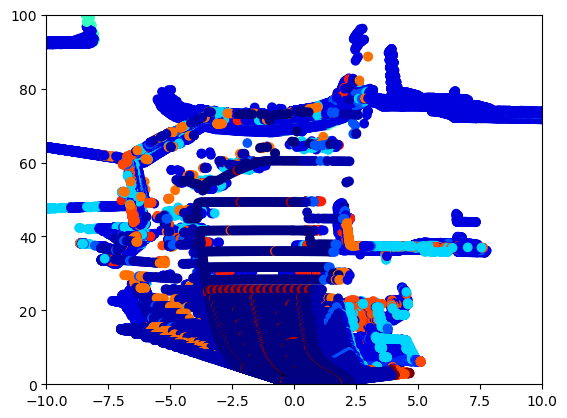

In [19]:
#we use np.division to quickly do elementwise matrix division where dividing by 0 equals 0

focal_mat=np.ones_like(rel_coords[:,:,0])
camera_index_mat=rel_coords

c_squared=np.square(focal_mat)+np.square(camera_index_mat[:,:,1])
d=np.power(np.square(camera_index_mat[:,:,0])+c_squared, 0.5*np.ones_like(camera_index_mat[:,:,0]))

#Create a condition to bypass the division incase of zeros
condition= (np.square(camera_index_mat[:,:,0]) + np.square(camera_index_mat[:,:,1]))!=0

#cant put a scalar in np.divide so we use ones
placeholder=np.ones_like(camera_index_mat[:,:,0])

a  = np.divide(placeholder, d, out=np.zeros_like(placeholder), where= condition)

x= a*normalized*(camera_index_mat[:,:,0]+1)
y= a*normalized*(camera_index_mat[:,:,1]+.75)
z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2)) #This loses some values but i cannot figure out why.

#Visualize
plt.scatter(x,z,c=segment_data[:,:,0],cmap='jet')
plt.xlim(-10,10)
plt.ylim(0,100)

In [20]:
import MapToGrid as m2g

#remove these after testing
reload(m2g)


x[np.isnan(x)==True]=0
y[np.isnan(y)==True]=0
z[np.isnan(z)==True]=0

# fig=plt.figure()
# ax=fig.add_subplot(projection='3d')
# ax.scatter(x,z,y,c=segment_data[:,:,0],cmap='jet')
# plt.xlim(-10,10)
# plt.ylim(0,100)

#todo: apply proper scaling 
#initiate grid 
map_width=120 
map_height=120*2
cell_size=0.1
costmap=np.zeros([int(map_width/cell_size),int(map_height/cell_size)])

#Cut out the usefull data we make it a 120m by 120m cube infront of the car
condition=((x>120) | (x<-120) |  (z<0) | (z>120))
x[condition] = 0
y[condition] = 0
z[condition] = 0

labels=segment_data[:,:,0]

# fig=plt.figure()
# ax=fig.add_subplot(projection='3d')
# ax.scatter(x,z,y,c=segment_data[:,:,0],cmap='jet')
# plt.xlim(-15,15)
# plt.ylim(0,100)

#transform to the grid 

# Call the updated map3grid function
cost_map = m2g.map3grid(costmap, x, z, labels, map_width, map_height, cell_size)
np.save(r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\costmap.npy', cost_map)

#determine costs 

#add to previous existing costmap 

#add vehicle layers 

#calculate motion primitives

[-100. -100. -100. ... -100. -100. -100.]


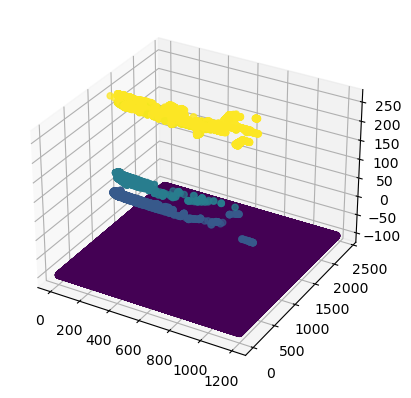

In [21]:
print(cost_map[3])
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
x_cost,y_cost=np.meshgrid(np.arange(len(cost_map[:,0])),np.arange(len(cost_map[0,:])))
ax.scatter(x_cost,y_cost,cost_map.flatten(),c=cost_map.flatten())

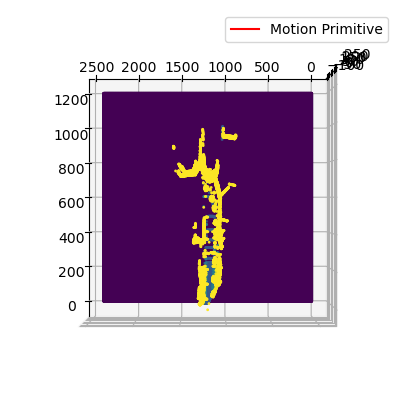

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def draw_motion_primitive(ax, start_x, start_y, distance, curvature_deg_per_meter, cell_size):
    curvature_rad_per_meter = np.radians(curvature_deg_per_meter)
    radius = 1 / curvature_rad_per_meter if curvature_deg_per_meter != 0 else float('inf')
    
    arc_length = distance
    if curvature_deg_per_meter != 0:
        arc_angle = distance * curvature_rad_per_meter  # arc length / radius
    else:
        arc_angle = 0
    
    theta = np.linspace(np.pi/2, np.pi/2 - arc_angle, num=300)
    
    if curvature_deg_per_meter != 0:
        x = start_x + radius * (1 - np.cos(theta))
        y = start_y + radius * np.sin(theta)
    else:
        x = start_x + np.linspace(0, distance, num=300)
        y = start_y * np.ones_like(x)
    
    ax.plot(x/cell_size, y/cell_size, 'r-', label='Motion Primitive')  # divide by cell size to scale to grid
    ax.legend()

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(5,5))
x_cost, y_cost = np.meshgrid(np.arange(cost_map.shape[0]), np.arange(cost_map.shape[1]))
ax.scatter(x_cost, y_cost, cost_map.flatten(), c=cost_map.flatten(), s=1)

# Draw motion primitive
start_x = 0  # Starting x position (in grid cells)
start_y = 125  # Starting y position (in grid cells)
distance = 5 / cell_size  # Distance for the primitive (in grid cells)
curvature_deg_per_meter = 5  # Curvature in degrees per meter

draw_motion_primitive(ax, start_x, start_y, distance, curvature_deg_per_meter, cell_size)

# Set the view to a top-down perspective from the left side
ax.view_init(elev=90, azim=180)

# Set limits for the axes
# ax.set_xlim([0, 50])
# ax.set_ylim([0, 1300])

plt.show()

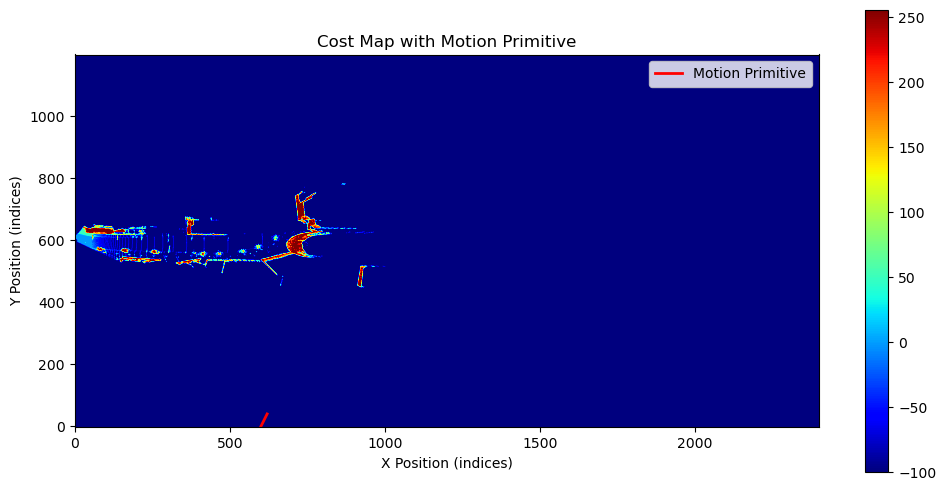

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cost map as a 2D image
c = ax.imshow(cost_map, cmap='jet', origin='lower')  # 'jet' is an example colormap, and 'lower' sets the [0,0] index of the array in the lower left corner of the axes
fig.colorbar(c, ax=ax)  # Optionally add a colorbar to show the cost values

# Define your motion primitive's path (x and y coordinates)
# This will depend on how your motion primitive data is structured
# The following is an example with made-up data for illustrative purposes
motion_primitive_x = np.array([600, 605, 610, 615, 620])  # Replace with actual x-coordinates (indices)
motion_primitive_y = np.array([0, 10, 20, 30, 40])        # Replace with actual y-coordinates (indices)

# Plot the motion primitive
ax.plot(motion_primitive_x, motion_primitive_y, 'r-', linewidth=2, label='Motion Primitive')

# Set labels and title
ax.set_xlabel('X Position (indices)')
ax.set_ylabel('Y Position (indices)')
ax.set_title('Cost Map with Motion Primitive')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [24]:
width =6
height =12
cell_size=0.1
np.zeros([int(width/cell_size),int(height/cell_size)])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(-2.5, 2.5)

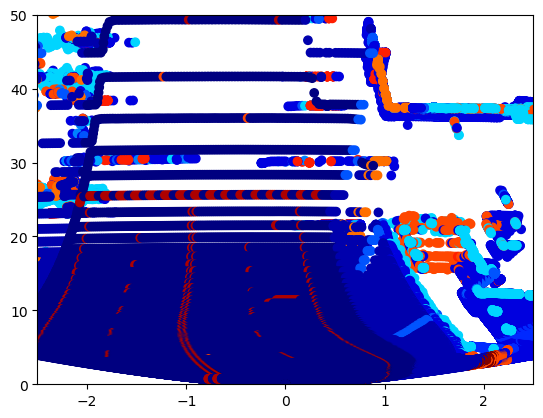

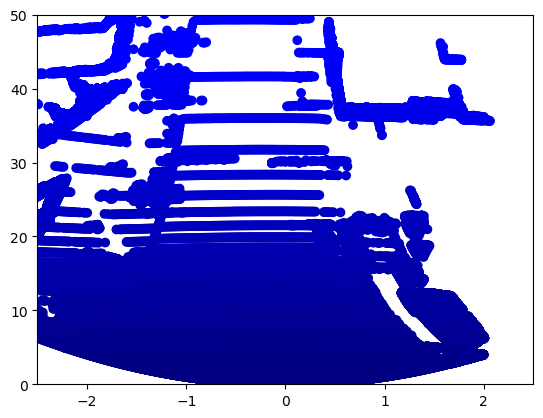

In [25]:
# Old plots I might keep for later
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,2/3),z,c=segment_data[:,:,0],cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)
#plt.xlim(0,-0.005)
#plt.ylim(0,1)
plt.figure()
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,1/2),z,c=normalized,cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)